In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [3]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [37]:
from ast import literal_eval
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from matplotlib.colors import LinearSegmentedColormap, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# for html to png
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options

from SSMuLA.de_simulations import DE_TYPES
from SSMuLA.zs_analysis import ZS_OPTS, ZS_COMB_OPTS
from SSMuLA.vis_summary import ZS_METRICS
from SSMuLA.get_corr import LANDSCAPE_ATTRIBUTES, val_list, zs_list
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, save_plt
from SSMuLA.util import checkNgen_folder


import os
from glob import glob
from tqdm import tqdm

import pandas as pd
import numpy as np

from ast import literal_eval

from scipy.stats import spearmanr

import bokeh
from bokeh.io import show, export_svg, export_png, output_notebook
from bokeh.plotting import show, figure
from bokeh.themes.theme import Theme


import holoviews as hv
from holoviews import opts, dim

from SSMuLA.landscape_global import get_file_name, n_mut_cutoff_dict
from SSMuLA.de_simulations import DE_TYPES
from SSMuLA.zs_analysis import ZS_OPTS, ZS_COMB_OPTS, ZS_OPTS_LEGEND
from SSMuLA.vis_summary import N_SAMPLE_LIST, N_MUT_SUBS, ZS_METRICS, ZS_N_MUTS
from SSMuLA.vis import LIB_COLORS, save_bokeh_hv
from SSMuLA.util import checkNgen_folder



# Custom colormap for the MSE row, using greens
cmap_mse = LinearSegmentedColormap.from_list(
    "mse_cmap_r", ["#FFFFFF", "#9bbb59"][::-1], N=100
)  # dark to light green

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(
    "bwg",
    [
        PRESENTATION_PALETTE_SATURATE["blue"],
        "white",
        PRESENTATION_PALETTE_SATURATE["green"],
    ],
    N=100,
)

de_metrics = ["mean_all", "fraction_max"]

simple_des = {
    "recomb_SSM": "Recomb",
    "single_step_DE": "Single step",
    "top96_SSM": "Top96 recomb",
}

In [72]:
ZS_COMB_OPTS

['struc-comb_score',
 'msanoif-comb_score',
 'msa-comb_score',
 'structnmsa-comb_score']

In [21]:
merge_csv = "results/corr_all/384/boosting|ridge-top96/actcut-1/merge_all.csv"
corr_csv = "results/corr_all/384/boosting|ridge-top96/actcut-1/corr.csv"
sub_dir = "results/style_dfs/actcut-1"
n_mut = "all"
metricr = "rho"

In [23]:
merge_df = pd.read_csv(merge_csv)

In [12]:
zs_csv = "results/zs_sum_2/min0/zs_stat_scale2max.csv"

In [13]:
zs_df = pd.read_csv(zs_csv)
zs_df

,lib,n_mut,scale_type,ed_score,Triad_score,ev_score,esm_score,esmif_score,struc-comb_score,msanoif-comb_score,msa-comb_score,structnmsa-comb_score
0,DHFR,all,max,"{'rho': 0.25115364784680605, 'ndcg': 0.9148031...","{'rho': 0.017800602737355977, 'ndcg': 0.874706...","{'rho': 0.3396500541186067, 'ndcg': 0.94705812...","{'rho': 0.2997147334642927, 'ndcg': 0.93412887...","{'rho': 0.3420102237927515, 'ndcg': 0.94530250...","{'rho': 0.21873645360229155, 'ndcg': 0.9010558...","{'rho': 0.3329620349497645, 'ndcg': 0.94020086...","{'rho': 0.35054254084284997, 'ndcg': 0.9449015...","{'rho': 0.3152181002051771, 'ndcg': 0.92293221..."
1,GB1,all,max,"{'rho': 0.1449275437059576, 'ndcg': 0.68739614...","{'rho': 0.2882819770014877, 'ndcg': 0.76404913...","{'rho': 0.18950853197890194, 'ndcg': 0.7215575...","{'rho': 0.08033543850645883, 'ndcg': 0.7016796...","{'rho': 0.29349648314848165, 'ndcg': 0.7536404...","{'rho': 0.3165424232001679, 'ndcg': 0.76648219...","{'rho': 0.14175871216515606, 'ndcg': 0.7115697...","{'rho': 0.21368724000610942, 'ndcg': 0.7341220...","{'rho': 0.2591091741511955, 'ndcg': 0.74743562..."
2,ParD2,all,max,"{'rho': 0.2975201855343516, 'ndcg': 0.90289769...","{'rho': 0.227369930630083, 'ndcg': 0.843745897...","{'rho': 0.44024813481122116, 'ndcg': 0.9153065...","{'rho': 0.508268170548332, 'ndcg': 0.945767955...","{'rho': 0.5471325552647406, 'ndcg': 0.94232035...","{'rho': 0.4297313521097985, 'ndcg': 0.90643478...","{'rho': 0.506389726205563, 'ndcg': 0.943912955...","{'rho': 0.55799750230795, 'ndcg': 0.9518303944...","{'rho': 0.5460244706565965, 'ndcg': 0.94510410..."
3,ParD3,all,max,"{'rho': 0.4566272705430452, 'ndcg': 0.95352503...","{'rho': 0.2845006278410668, 'ndcg': 0.88616858...","{'rho': 0.4605763343621608, 'ndcg': 0.95588218...","{'rho': 0.5830921549165025, 'ndcg': 0.97249924...","{'rho': 0.6008140740078155, 'ndcg': 0.94168720...","{'rho': 0.4805622322100395, 'ndcg': 0.91576427...","{'rho': 0.5429575450092126, 'ndcg': 0.96828106...","{'rho': 0.6109746458267433, 'ndcg': 0.96292848...","{'rho': 0.6497908043137078, 'ndcg': 0.95470974..."
4,TrpB3A,all,max,"{'rho': 0.1465185000668908, 'ndcg': 0.67247990...","{'rho': -0.016551815668742573, 'ndcg': 0.48869...","{'rho': 0.10589219156383854, 'ndcg': 0.7436851...","{'rho': 0.1477359747078168, 'ndcg': 0.72130165...","{'rho': 0.13230084383239168, 'ndcg': 0.7544885...","{'rho': 0.06578455199258033, 'ndcg': 0.5599543...","{'rho': 0.13010789216014215, 'ndcg': 0.7440516...","{'rho': 0.13486186584451068, 'ndcg': 0.7474028...","{'rho': 0.10732339639256146, 'ndcg': 0.6108842..."
5,TrpB3B,all,max,"{'rho': 0.04845065518943543, 'ndcg': 0.6383177...","{'rho': 0.041425372339958653, 'ndcg': 0.348851...","{'rho': 0.05659007301204791, 'ndcg': 0.6725036...","{'rho': 0.08009647530851007, 'ndcg': 0.7076244...","{'rho': 0.057266784696617806, 'ndcg': 0.735295...","{'rho': 0.06044103383312873, 'ndcg': 0.4315667...","{'rho': 0.07316647282559174, 'ndcg': 0.6992106...","{'rho': 0.07061606988878223, 'ndcg': 0.7048014...","{'rho': 0.0733495368406833, 'ndcg': 0.64306839..."
6,TrpB3C,all,max,"{'rho': 0.05599922068888013, 'ndcg': 0.6462084...","{'rho': 0.04358095980591121, 'ndcg': 0.6801866...","{'rho': 0.050793415415770725, 'ndcg': 0.660262...","{'rho': 0.01875548463899675, 'ndcg': 0.6718203...","{'rho': 0.05379038793196573, 'ndcg': 0.6707697...","{'rho': 0.05717101568469483, 'ndcg': 0.6856194...","{'rho': 0.034389436099311325, 'ndcg': 0.666372...","{'rho': 0.0440309847446764, 'ndcg': 0.67793137...","{'rho': 0.04761116784175334, 'ndcg': 0.6810332..."
7,TrpB3D,all,max,"{'rho': 0.1192533236522955, 'ndcg': 0.75037476...","{'rho': 0.21394615695861952, 'ndcg': 0.7617405...","{'rho': 0.23318169520052792, 'ndcg': 0.8229366...","{'rho': 0.2221583642505299, 'ndcg': 0.81546080...","{'rho': 0.1834269667317289, 'ndcg': 0.79220106...","{'rho': 0.21711186961077883, 'ndcg': 0.7932915...","{'rho': 0.23376357589702845, 'ndcg': 0.8228904...","{'rho': 0.2243380268708318, 'ndcg': 0.81455991...","{'rho': 0.23411901818791084, 'n

In [26]:
n_mut = "all"

zs_df_list = [zs_df[["lib", "n_mut"]]]
# Create new columns for each score type
for c in ZS_OPTS + ZS_COMB_OPTS:

    zs_name = c.replace("_score", "")
    zs_df_list.append(
        zs_df[f"{zs_name}_score"]
        .str.replace(": nan", ": None")
        .apply(literal_eval)
        .apply(pd.Series)
        .rename(columns={m: f"{zs_name}_{m}" for m in ZS_METRICS})
    )

zs_df_expend = pd.concat(zs_df_list, axis=1)

zs_mut_df_list = [zs_df_expend[zs_df_expend["n_mut"] == n_mut]["lib"]]
for n_mut in ZS_N_MUTS:
    slice_df = (
        zs_df_expend[zs_df_expend["n_mut"] == n_mut]
        .drop(columns=["lib", "n_mut"])
        .reset_index(drop=True)
    )
    zs_mut_df_list.append(
        slice_df.rename(columns={c: f"{n_mut}_{c}" for c in slice_df.columns})
    )
zs = pd.concat(zs_mut_df_list, axis=1)
zs

,lib,all_ed_rho,all_ed_ndcg,all_ed_rocauc,all_Triad_rho,all_Triad_ndcg,all_Triad_rocauc,all_ev_rho,all_ev_ndcg,all_ev_rocauc,...,single_struc-comb_rocauc,single_msanoif-comb_rho,single_msanoif-comb_ndcg,single_msanoif-comb_rocauc,single_msa-comb_rho,single_msa-comb_ndcg,single_msa-comb_rocauc,single_structnmsa-comb_rho,single_structnmsa-comb_ndcg,single_structnmsa-comb_rocauc
0,DHFR,0.251154,0.914803,0.719973,0.017801,0.874707,0.452238,0.339650,0.947058,0.912765,...,0.304167,0.583005,0.891175,0.917361,0.553279,0.891577,0.911111,-0.212895,0.800908,0.320833
1,GB1,0.144928,0.687396,0.577572,0.288282,0.764049,0.715632,0.189509,0.721558,0.627690,...,0.916196,0.260675,0.686378,0.588512,0.774073,0.784778,0.897363,0.811746,0.786033,0.916196
2,ParD2,0.297520,0.902898,0.552103,0.227370,0.843746,0.652049,0.440248,0.915307,0.664011,...,0.964912,0.579624,0.969377,0.842105,0.676766,0.976464,0.947368,0.687594,0.988024,0.964912
3,ParD3,0.456627,0.953525,0.564976,0.284501,0.886169,0.906254,0.460576,0.955882,0.705520,...,NaN,0.321146,0.993785,NaN,0.369282,0.995510,NaN,0.337783,0.993260,NaN
4,TrpB3A,0.146519,0.672480,0.608694,-0.016552,0.488693,0.664616,0.105892,0.743685,0.657328,...,0.622685,0.505150,0.887328,0.862269,0.490425,0.892182,0.850694,0.097446,0.525140,0.646991
5,TrpB3B,0.048451,0.638318,0.551217,0.041425,0.348852,0.653659,0.056590,0.672504,0.583225,...,0.759259,0.361793,0.914430,0.975309,0.373545,0.924416,0.981481,0.155952,0.795325,0.796296
6,TrpB3C,0.055999,0.646208,0.605496,0.043581,0.680187,0.621564,0.050793,0.660263,0.539872,...,1.000000,0.264137,0.873296,0.981818,0.380206,0.942209,1.000000,0.336462,0.934191,0.996970
7,TrpB3D,0.119253,0.750375,0.609910,0.213946,0.761741,0.751696,0.233182,0.822937,0.785684,...,0.672457,0.497656,0.875823,0.745658,0.408905,0.854952,0.682382,0.386136,0.814950,0.699132
8,TrpB3E,0.013191,0.728204,0.563633,-0.017332,0.593711,0.504706,0.017571,0.852058,0.515337,...,0.401722,0.718998,0.938319,0.991392,0.692477,0.914564,0.958393,-0.076301,0.511023,0.467719
9,TrpB3F,0.209446,0.763770,0.865507,0.093448,0.688977,0.865511,0.103260,0.804297,0.873863,...,0.720844,0.446829,0.872552,0.617246,0.375107,0.868215,0.634615,0.500940,0.903963,0.714640


In [24]:
active_lib_list = merge_df["lib"].tolist()
active_lib_list

['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [58]:
ZS_OPTS

['ed_score', 'Triad_score', 'ev_score', 'esm_score', 'esmif_score']

In [53]:
[c for c in zs.columns if "all_" in c and "_rho" in c and "-comb" not in c]

['all_ed_rho', 'all_Triad_rho', 'all_ev_rho', 'all_esm_rho', 'all_esmif_rho']

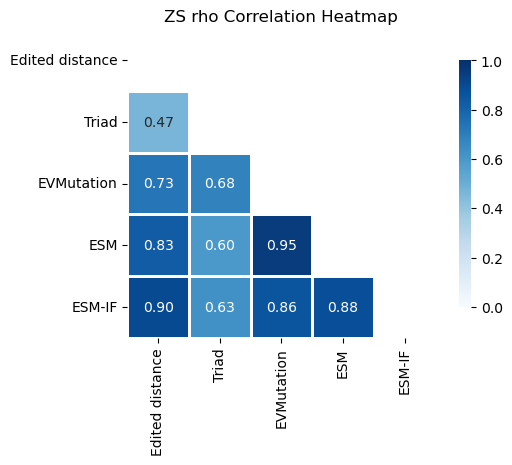

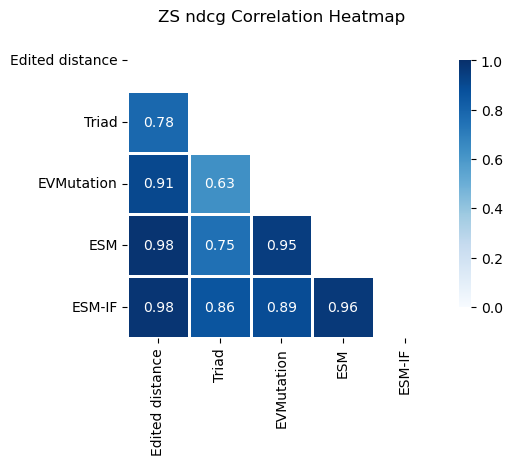

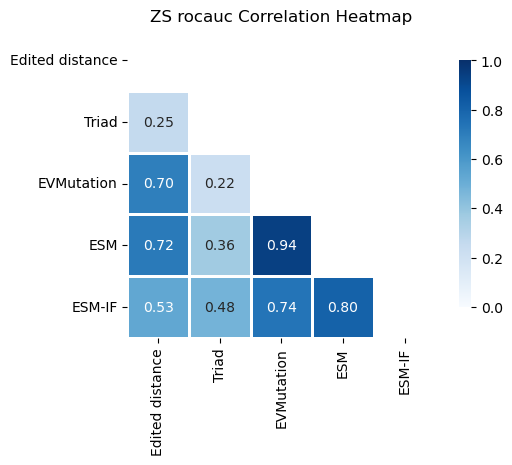

In [55]:
for zsm in ZS_METRICS:
    sel_cols = [c for c in zs.columns if "all_" in c and f"_{zsm}" in c and "-comb" not in c]
    sel_col_dict = {
        k: ZS_OPTS_LEGEND[k.split("_")[1]+ "_score"] for k in sel_cols
    }
    
    corr_matrix = zs[zs["lib"].isin(active_lib_list)][sel_cols].rename(columns=sel_col_dict).corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=(6, 4))

    # Draw the heatmap with the mask
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="Blues",
                cbar_kws={"shrink": .8}, linewidths=.8, square=True, vmin=0, vmax=1)

    # Add titles and labels as necessary
    plt.title(f'ZS {zsm} Correlation Heatmap')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for zsm, ax in zip(["rho", "rocauc"], axes):
    sel_cols = [c for c in zs.columns if "all_" in c and f"_{zsm}" in c and "-comb" not in c]
    sel_col_dict = {
        k: ZS_OPTS_LEGEND[k.split("_")[1]+ "_score"] for k in sel_cols
    }
    
    corr_matrix = zs[zs["lib"].isin(active_lib_list)][sel_cols].rename(columns=sel_col_dict).corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Draw the heatmap with the mask
    ax = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="Blues", cbar=False, 
                cbar_kws={"shrink": .8}, linewidths=.8, square=True, vmin=0, vmax=1)

    # Add titles and labels as necessary
    ax.set_title(f'ZS {zsm} Correlation Heatmap')
fig.colorbar(heatmap.collections[0], ax=[ax1, ax2], location='right', aspect=10)


In [56]:
[c for c in merge_df.columns if "top_maxes" in c]

['top_maxes',
 'top_maxes_Triad',
 'top_maxes_esm',
 'top_maxes_esmif',
 'top_maxes_ev',
 'top_maxes_msa-comb',
 'top_maxes_msanoif-comb',
 'top_maxes_struc-comb',
 'top_maxes_structnmsa-comb',
 'top_maxes_double',
 'top_maxes_single']

In [62]:
list(ZS_OPTS_LEGEND.values())[:6]

['Random', 'Edited distance', 'Triad', 'EVMutation', 'ESM', 'ESM-IF']

Text(0.5, 1.0, 'ftMLDE max fitness achieved')

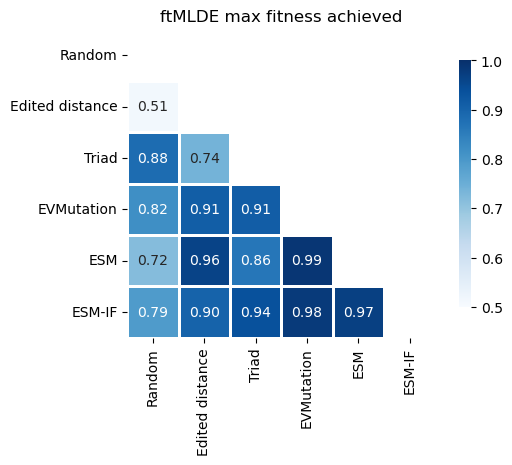

In [69]:
# Calculate the correlation matrix
ft_df = merge_df[
        [
            "top_maxes",
            "top_maxes_double",
            "top_maxes_Triad",
            "top_maxes_ev",
            "top_maxes_esm",
            "top_maxes_esmif",
        ]
    ]
ft_df.columns = list(ZS_OPTS_LEGEND.values())[:6]

corr_matrix = ft_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"shrink": 0.8},
    linewidths=0.8,
    square=True,
    vmin=0.5,
    vmax=1,
)  # Setting vmin and vmax

# Add titles and labels as necessary
plt.title("ftMLDE max fitness achieved")

Text(0.5, 1.0, 'ftMLDE fitness = 1 achieved')

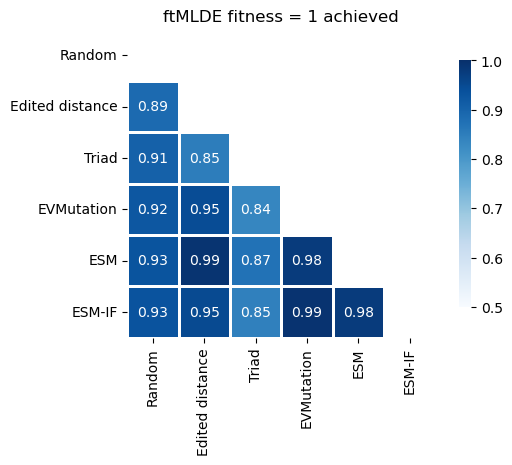

In [70]:
# Calculate the correlation matrix
ft_opt = "if_truemaxs"
ft_df = merge_df[
        [
            ft_opt,
            f"{ft_opt}_double",
            f"{ft_opt}_Triad",
            f"{ft_opt}_ev",
            f"{ft_opt}_esm",
            f"{ft_opt}_esmif",
        ]
    ]
ft_df.columns = list(ZS_OPTS_LEGEND.values())[:6]

corr_matrix = ft_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"shrink": 0.8},
    linewidths=0.8,
    square=True,
    vmin=0.5,
    vmax=1,
)  # Setting vmin and vmax

# Add titles and labels as necessary
plt.title("ftMLDE fitness = 1 achieved")

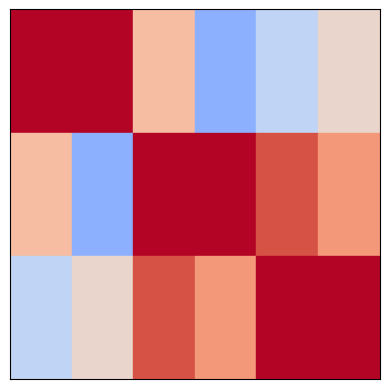

In [71]:
import numpy as np

# Simulated correlation matrices for two subgroups
data1 = np.array([
    [1, 0.3, -0.2],
    [0.3, 1, 0.8],
    [-0.2, 0.8, 1]
])

data2 = np.array([
    [1, -0.5, 0.1],
    [-0.5, 1, 0.5],
    [0.1, 0.5, 1]
])

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to add a half-colored cell
def add_half_colored_cell(ax, value1, value2, left, bottom, width, height, cmap, vmin, vmax):
    # Calculate colors from value
    color1 = cmap((value1 - vmin) / (vmax - vmin))
    color2 = cmap((value2 - vmin) / (vmax - vmin))
    
    # Create two rectangles (half cells)
    ax.add_patch(Rectangle((left, bottom), width/2, height, color=color1))
    ax.add_patch(Rectangle((left + width/2, bottom), width/2, height, color=color2))

# Setup figure and axis
fig, ax = plt.subplots()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

# Loop through data to plot each cell
n = len(data1)
for i in range(n):
    for j in range(n):
        add_half_colored_cell(ax, data1[i, j], data2[i, j], j, n-1-i, 1, 1, plt.cm.coolwarm, -1, 1)

# Set aspect of the plot to be equal
ax.set_aspect('equal')

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()
